## Control con método Monte Carlo
El método Monte Carlo para realizar tareas de control, itera entre dos pasos para intentar generar una política óptima:
1. Evaluación de la política: Usa una política $\pi$ para generar episodios y realizar la estimación de Q. Esencialmente es aplicar el algoritmo de predicción Monte Carlo de la anterior práctica, pero iniciando con una política estocástica *epsilon-greedy* con $\epsilon=1$ (o sea acciones totalmente aleatorias).
2. Mejora de la política: Se actualiza la política siendo *epsilon-greedy* con respecto a la función Q.
Cabe destacar que un cambio importante es que no se estima la función Q exacta para cada política que se va generando, sino que sólo se estima en un episodio y se considera como suficiente para ser utilizada para mejorar la política. Para actualizar la política se usa la ecuación:
$$ Q(St,At) = Q(St,At) + 1/N(St,At).(Gt-Q(St,At)) $$
Una versión de este método que es muy útil para problemas no estacionarios (en donde ante un estado y una acción no siempre se da la misma recompensa), es la versión **"Constant Alpha"**, en donde $1/N(St,At)$ se considera como una constante. Quedando:
$$ Q(St,At) = Q(St,At) + \alpha (Gt - Q(St,At)) $$
Esta es la versión que se implementa en el presente código para el entorno *Blackjack*

#### Funciones que se usarán

In [1]:
import numpy as np
import collections
import gymnasium as gym

Esta función calcula las probabilidades de las acciones de ser escogidas.

Se asigna la probabilidad **$ \epsilon/A(s) $** a todas las acciones y posteriormente la probabilidad **$ 1-\epsilon + \epsilon/|A(s)| $** a la acción *greedy*

In [2]:
def obtener_probabilidades(Q_s, epsilon, nA):
    politica_s = np.ones(nA) * epsilon / nA # todas las acciones tienen probabilidad epsilon/nA(en este caso hay dos acciones pero en otros ambientes habrá mas)
    max_accion = np.argmax(Q_s)
    politica_s[max_accion] = 1 - epsilon + (epsilon / nA) # max_accion tiene la probabilidad 1-epsilon de ser elegida
    return politica_s

In [3]:
# Función para generar un episodio usando la politica epsilon-greedy
def generate_episode_from_Q(ambiente, Q, epsilon, nA):
    episodio = []
    estado = ambiente.reset()[0]
    
    while True:
        probabilidades = obtener_probabilidades(Q[estado], epsilon, nA)
        accion = np.random.choice(np.arange(nA), p=probabilidades) if estado in Q else ambiente.action_space.sample() # Si el estado no esta en Q, se elige una accion aleatoria
        
        nuevo_estado, recompensa, is_done, trunc, info = ambiente.step(accion)
        episodio.append((estado, accion, recompensa))
        estado = nuevo_estado
        
        if is_done:
            break
    
    return episodio

# Función para actualizar la función Q
def actualizar_Q(ambiente, episodio, Q, ALPHA, GAMMA):
    estados, acciones, recompensas = zip(*episodio)
    
    for index, estado in enumerate(estados):
        old_Q = Q[estado][acciones[index]]
        Q[estado][acciones[index]] = old_Q + ALPHA * (sum(r*GAMMA**k for k, r in enumerate(recompensas[index:])) - old_Q) # Actualización de Q
        
    return Q

In [4]:

def ControlMonteCarlo(ambiente, num_episodios, ALPHA, EPS_DECAY, GAMMA):
    EPS_INICIO = 1.0 # Valor inicial de epsilon
    EPS_MIN = 0.05 # Valor mínimo de epsilon al que decaerá
    
    nA = ambiente.action_space.n # Número de acciones
    Q = collections.defaultdict(lambda: np.zeros(nA))
    
    epsilon = EPS_INICIO
    
    for episode in range(1, num_episodios+1):
        epsilon = max(epsilon*EPS_DECAY, EPS_MIN) # Decaimiento de epsilon (se toma el máximo para que no sea menor a EPS_MIN)
        episodio_generado = generate_episode_from_Q(ambiente, Q, epsilon, nA)
        Q = actualizar_Q(ambiente, episodio_generado, Q, ALPHA, GAMMA) # Actualización de Q
        
    politica = dict((estado, np.argmax(acciones)) for estado, acciones in Q.items()) # Creación de la política óptima
    return politica, Q



Función para graficar en 3D

In [5]:
# source  https://github.com/udacity/deep-reinforcement-learning/blob/master/monte-carlo/plot_utils.py

import matplotlib.pyplot as plt

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)

        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)
        ax.set_zlim(-1, 1);
        return surf

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('As Usable')
    surf = get_figure(True, ax)
    fig.colorbar(surf, shrink=0.5, aspect=15)
    plt.show()

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('As No Usable')
    surf = get_figure(False, ax)
    fig.colorbar(surf, shrink=0.5, aspect=15)
    plt.show()

Función para graficar política

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# source  https://github.com/udacity/deep-reinforcement-learning/blob/master/monte-carlo/plot_utils.py
def plot_policy(policy):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in policy:
            return policy[x,y,usable_ace]
        else:
            return 1

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(10, 0, -1)
        X, Y = np.meshgrid(x_range, y_range)
        Z = np.array([[get_Z(x,y,usable_ace) for x in x_range] for y in y_range])
        surf = ax.imshow(Z, cmap=plt.get_cmap('tab20c', 2), vmin=0, vmax=1, extent=[10.5, 21.5, 0.5, 10.5])
        plt.xticks(x_range)
        plt.yticks(y_range)
        plt.gca().invert_yaxis()
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.grid(color='w', linestyle='-', linewidth=1)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = plt.colorbar(surf, ticks=[0,1], cax=cax)
        cbar.ax.set_yticklabels(['0 (STICK)','1 (HIT)'])
            
    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(121)
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    plt.show()

    fig = plt.figure(figsize=(15, 15))
    ax = fig.add_subplot(122)
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

#### Entrenamiento

In [7]:
ambiente = gym.make('Blackjack-v1')

num_episodios = 1000000
ALPHA = 0.02 # Tasa de aprendizaje
EPS_DECAY = 0.9999965 # Valor de decaimento do epsilon
GAMMA = 1.0 # Factor de descuento

politica, Q = ControlMonteCarlo(ambiente, num_episodios, ALPHA, EPS_DECAY, GAMMA)

c:\PYTHON\Python387\lib\site-packages\gymnasium\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


#### Visualizar resultados

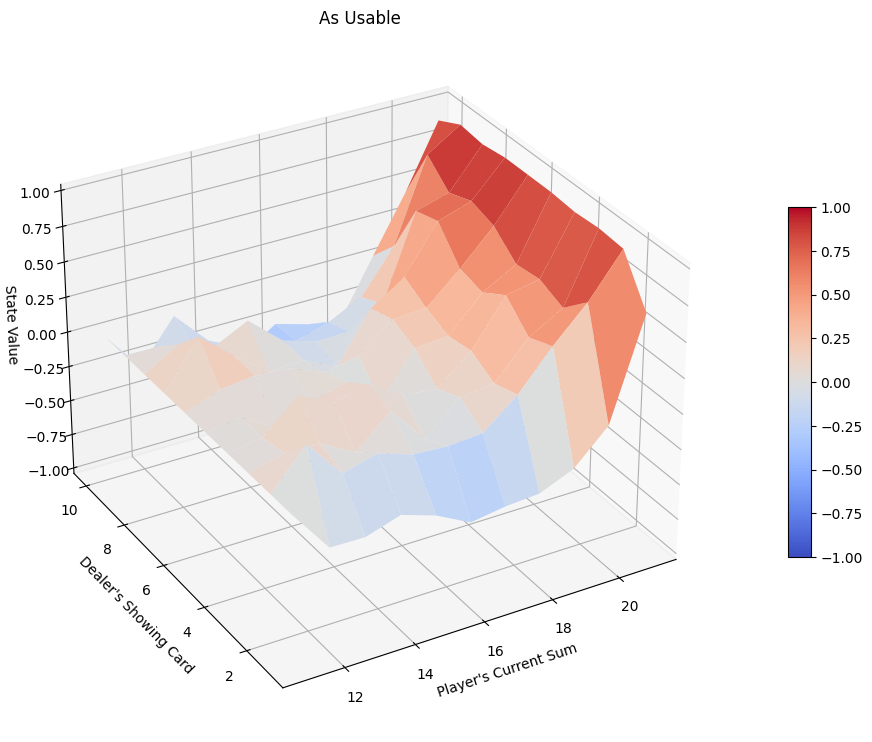

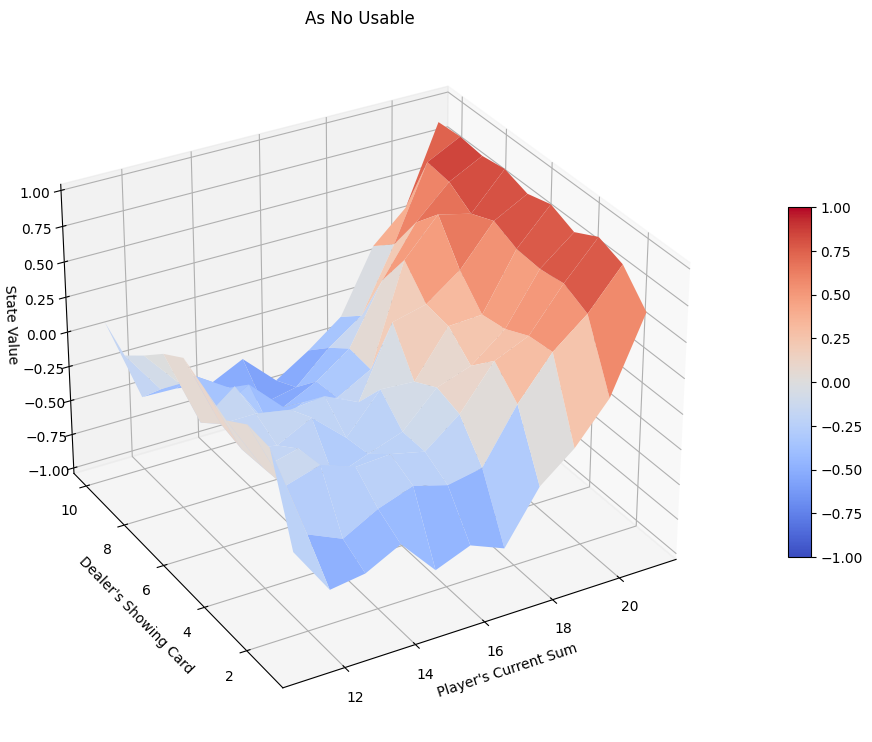

In [8]:
V = dict((estado, np.max(acciones)) for estado, acciones in Q.items())
plot_blackjack_values(V)

#### Comparar las políticas de la práctica anterior con la obtenida con el método Monte Carlo

##### Funciones

In [9]:
# Política simple
def politica_simple(estado):
    accion = 0 if estado[0] > 19 else 1
    return accion

# Política estocástica
def politica_estocastica(estado):
    probabilidades = [0.9, 0.1] if estado[0] > 15 else [0.1, 0.9]
    accion = np.random.choice(np.arange(2), p=probabilidades)
    return accion

# Política óptima
def politica_optima(estado):
    if estado in politica:
        accion = politica[estado]
    else:
        accion = politica_estocastica(estado)
    return accion

# Función para comparar políticas
def test(politica, test_episodes=1000000):
    ambiente = gym.make('Blackjack-v1', render_mode='rgb_array')
    losing = 0.0
    winning = 0.0
    drawing = 0.0
    
    for n in range(test_episodes):
        estado = ambiente.reset()[0]
        while True:
            accion = politica(estado)
            nuevo_estado, nueva_recompensa, is_done, trunc, info = ambiente.step(accion)
            if is_done:
                if nueva_recompensa==-1.0: losing += 1
                if nueva_recompensa==1.0: winning += 1
                if nueva_recompensa==0.0: drawing += 1
                break
            estado = nuevo_estado
            
    losing /= test_episodes
    winning /= test_episodes
    drawing /= test_episodes
    
    return losing, winning, drawing

##### Comparación

In [10]:
num_episodios = 100000
#Evaluar política simple
losing, winning, drawing = test(politica_simple, num_episodios)
print(f'Política simple: losing={losing}, winning={winning}, drawing={drawing} episodios={num_episodios}')

# Evaluar política estocástica
losing, winning, drawing = test(politica_estocastica, num_episodios)
print(f'Política estocástica: losing={losing}, winning={winning}, drawing={drawing} episodios={num_episodios}')

# Evaluar política óptima
losing, winning, drawing = test(politica_optima, num_episodios)
print(f'Política óptima: losing={losing}, winning={winning}, drawing={drawing} episodios={num_episodios}')

Política simple: losing=0.64595, winning=0.29857, drawing=0.05548 episodios=100000
Política estocástica: losing=0.52979, winning=0.38665, drawing=0.08356 episodios=100000
Política óptima: losing=0.48701, winning=0.43114, drawing=0.08185 episodios=100000


Visualizar política, observar que la política óptima sí toma en consideración si el crupier posee o no un as

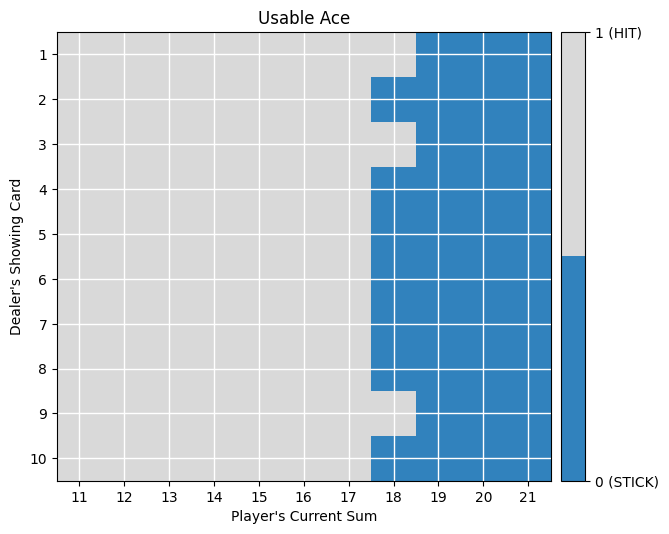

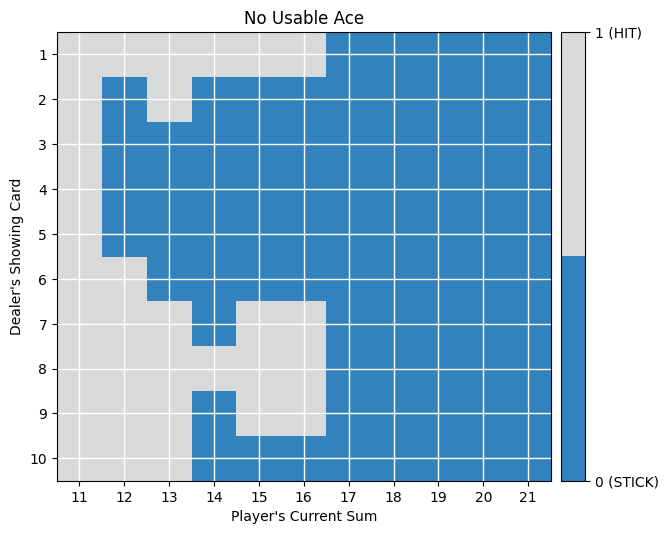

In [11]:
plot_policy(politica)